# 因子开发与回测示例

本 Notebook 展示了如何使用 `longgang_trader` 框架进行一次完整的因子开发和回测流程。

## 1. 加载数据

In [ ]:
from longgang_trader.data.data_loader import DataLoader

# 初始化数据加载器（此处应有配置文件）
dl = DataLoader(config={...})

# 加载数据
stock_data = dl.load_stock_data([...]) # type: ignore

## 2. 计算因子

In [ ]:
from longgang_trader.alpha.factor_calculator import MomentumFactor, FactorCalculator

# 创建一个20日动量因子
mom_factor = MomentumFactor(window=20)

# 使用因子计算器
calculator = FactorCalculator(stock_data)
calculator.add_factor(mom_factor)
factor_df = calculator.run()

## 3. 因子检验

In [ ]:
from longgang_trader.alpha.factor_testing import FactorTester

# 准备收益率数据
returns_data = ...

# 初始化因子检验器
tester = FactorTester(factor_df, returns_data, ...)

# 运行检验并查看结果
tester.run_all_tests()

## 4. 回测

In [ ]:
from longgang_trader.backtesting.backtester import Backtester, BaseStrategy

# 定义一个简单的分层回测策略
class SimpleLayeredStrategy(BaseStrategy):
    def generate_signals(self, current_date, current_positions):
        # 在每个调仓日，买入因子值最高的10%的股票，卖出最低的10%
        pass

# 初始化策略和回测器
strategy = SimpleLayeredStrategy(factor_df)
bt = Backtester(strategy, stock_data, initial_capital=10000000, transaction_cost=0.001)

# 运行回测
# 在运行前，请确保已经编译了Rust核心: `cargo build --release`
bt.run_backtest()

# 查看表现
bt.plot_equity_curve()
print(bt.calculate_performance_metrics())

## 虚拟数据测试

In [2]:
import rqdatac, pandas, datetime

rqdatac.init()


d:\Program Files\Conda\Lib\site-packages\rqdatac\client.py:224: UserWarning: rqdatac is already inited. Settings will be changed.
  warnings.warn("rqdatac is already inited. Settings will be changed.", stacklevel=0)


In [3]:
index_components = rqdatac.index_components('000300.XSHG', date=datetime.date(2025, 11, 6))

In [7]:
data_list = []
for symbol in index_components:
    df = rqdatac.get_price(symbol, start_date=20251001, end_date="2025-11-01")
    data_list.append(df)
all_data = pandas.concat(data_list)

In [11]:
all_data.to_parquet("test_data.parquet")

In [1]:
import pandas as pd
stock_data = pd.read_parquet("test_data.parquet")
stock_data = stock_data.reset_index()
factor_data = stock_data[["order_book_id", "date"]].copy()
factor_data["factor_value"] = stock_data.groupby("order_book_id")["close"].rolling(5).mean().values
factor_data.fillna(0.0,inplace=True)

In [2]:
import sys
import os

# 将项目根目录添加到 Python 的模块搜索路径中
# 这使得 Notebook 可以成功导入 'longgang_trader' 模块
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"项目根目录已添加至 sys.path: {project_root}")

# 验证：现在应该可以成功导入了
try:
    import longgang_trader
    print("模块 'longgang_trader' 导入成功！")
except ImportError:
    print("错误：仍然无法导入 'longgang_trader'。")
from longgang_trader.backtesting.backtester import Backtester, BaseStrategy
import pandas as pd

# 定义一个简单的分层回测策略
class SimpleLayeredStrategy(BaseStrategy):
    """一个简单的策略，在每个交易日，等权重买入因子值最高的一只股票"""
    def generate_signals_for_all_dates(self):
        # 合并因子数据，方便处理
        data = self.factor_data.copy()
        
        # 在每个日期，找到因子值最高的股票
        top_stocks = data.loc[data.groupby('date')['factor_value'].idxmax()]
        
        # 设置目标权重为1.0
        top_stocks['target_weight'] = 1.0
        
        signals = top_stocks[['date', 'order_book_id', 'target_weight']]
        #signals.columns = ['date', 'symbol', 'target_weight']
        
        print("\n生成的交易信号 (signals):")
        print(signals)
        return signals

# --- 运行回测 ---
print("\n--- 开始执行回测 ---")
# 1. 初始化策略
strategy = SimpleLayeredStrategy(factor_data)


项目根目录已添加至 sys.path: d:\Notes\Project\LongGangTrader
模块 'longgang_trader' 导入成功！

--- 开始执行回测 ---


In [6]:

# 2. 初始化回测器
# 注意：确保你已经成功运行了 `maturin develop`
config_dict = {
    "initial_capital": 10_000_000.0,
    "transaction_cost": 0.001,
    "symbol_col": "order_book_id",
    "date_col": "date",
    "close_col": "close"
}
bt = Backtester(
    strategy=strategy,
    data=stock_data,
    config=config_dict
)

# 3. 运行回测（这将调用 Rust 核心）
bt.run_backtest()



生成的交易信号 (signals):
           date order_book_id  target_weight
0    2025-10-09   002714.XSHE            1.0
1    2025-10-10   002714.XSHE            1.0
2    2025-10-13   002714.XSHE            1.0
3    2025-10-14   002714.XSHE            1.0
2724 2025-10-15   600690.XSHG            1.0
2725 2025-10-16   600690.XSHG            1.0
2726 2025-10-17   600690.XSHG            1.0
2727 2025-10-20   600690.XSHG            1.0
2728 2025-10-21   600690.XSHG            1.0
2729 2025-10-22   600690.XSHG            1.0
2730 2025-10-23   600690.XSHG            1.0
2731 2025-10-24   600690.XSHG            1.0
2732 2025-10-27   600690.XSHG            1.0
4977 2025-10-28   000725.XSHE            1.0
4978 2025-10-29   000725.XSHE            1.0
4979 2025-10-30   000725.XSHE            1.0
4980 2025-10-31   000725.XSHE            1.0
Rust 回测成功完成。


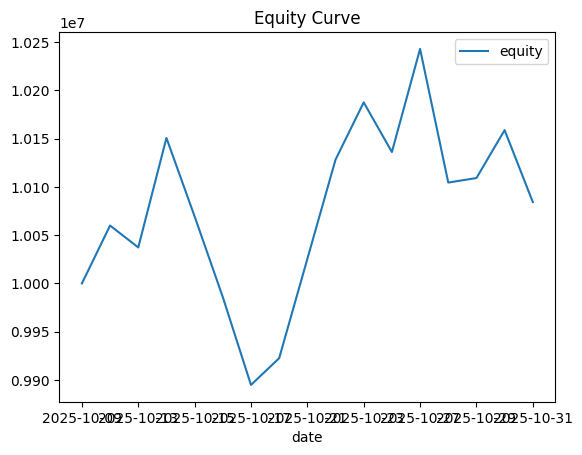

In [7]:

# 4. 查看表现
portfolio_history = bt.get_portfolio_history()

# 如果有结果，可以绘制资金曲线
if portfolio_history is not None and not portfolio_history.empty:
    portfolio_history.plot(x='date', y='equity', title='Equity Curve')

In [8]:
portfolio_history

,date,equity,cash,holdings_value
0,2025-10-09,1.000000e+07,-10000.000000,-0.000000e+00
1,2025-10-10,1.006001e+07,-10.000000,1.007001e+07
2,2025-10-13,1.003732e+07,-0.010000,1.003733e+07
3,2025-10-14,1.015073e+07,-0.000010,1.015073e+07
4,2025-10-15,1.006945e+07,-20138.901524,1.006945e+07
5,2025-10-16,9.985907e+06,-20.138902,1.000605e+07
6,2025-10-17,9.894926e+06,-0.020139,9.894946e+06
7,2025-10-20,9.922610e+06,-0.000020,9.922610e+06
8,2025-10-21,1.002543e+07,-0.000020,1.002543e+07
9,2025-10-22,1.012826e+07,-0.000020,1.012826e+07
